In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"norihisa","key":"d016ea67c3249f44d2090f6c16a2ade1"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!pip install kaggle

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d rush4ratio/video-game-sales-with-ratings

  0% 0.00/503k [00:00<?, ?B/s]
100% 503k/503k [00:00<00:00, 69.6MB/s]


In [0]:
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt   
import seaborn as sns
from IPython.display import Image, display        
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from time import gmtime, strftime                 
import sys                                        
import math                                       
import json
import boto3

In [7]:
!unzip video-game-sales-with-ratings.zip

Archive:  video-game-sales-with-ratings.zip
  inflating: Video_Games_Sales_as_at_22_Dec_2016.csv  


In [9]:
# PandasのデータフレームへCSVファイルを変換
data = pd.read_csv('./Video_Games_Sales_as_at_22_Dec_2016.csv')
data.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


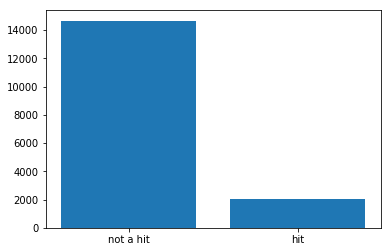

In [10]:
# ターゲットを設定
# Global_Salesで1（100万本）以上の売上を基準としてyを作成
data['y'] = (data['Global_Sales'] > 1)
 
# ターゲットの分布を確認
plt.bar(['not a hit', 'hit'], data['y'].value_counts())
plt.show()

In [11]:
data['y'].head()

0    True
1    True
2    True
3    True
4    True
Name: y, dtype: bool

In [12]:
# 欠損データの確認 missing_values_tableを作る
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum()/len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns= {0 : 'Missing Values', 1: '% of total values'})
    return mis_val_table_ren_columns

# 欠損データの状況を確認
missing_values_table(data) 

,Missing Values,% of total values
Name,2,0.011962
Platform,0,0.000000
Year_of_Release,269,1.608948
Genre,2,0.011962
Publisher,54,0.322986
NA_Sales,0,0.000000
EU_Sales,0,0.000000
JP_Sales,0,0.000000
Other_Sales,0,0.000000
Global_Sales,0,0.000000


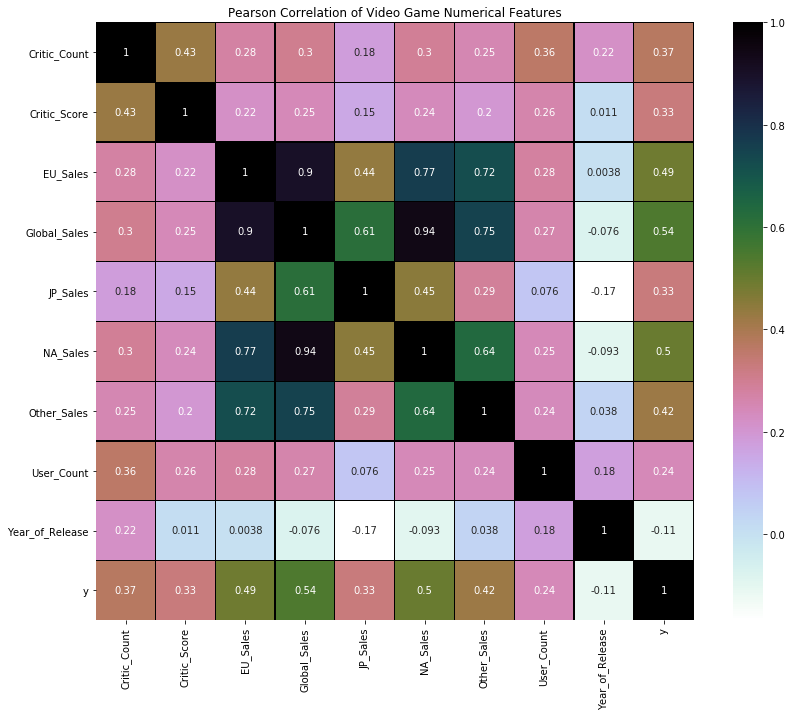

In [13]:
str_list = []
for colname, colvalue in data.iteritems():
    if type(colvalue[2]) == str:
         str_list.append(colname)
# Get to the numeric columns by inversion            
num_list = data.columns.difference(str_list) 
# Create Dataframe containing only numerical features
data_num = data[num_list]
f, ax = plt.subplots(figsize=(14, 11))
plt.title('Pearson Correlation of Video Game Numerical Features')
# Draw the heatmap using seaborn
sns.heatmap(data_num.astype(float).corr(),linewidths=0.25,vmax=1.0, 
            square=True, cmap="cubehelix_r", linecolor='k', annot=True)

In [14]:
# 各項目の度数分布の表を作成
for column in data.select_dtypes(include=['object']).columns:
  display(pd.crosstab(index=data[column], 
                      columns='% observations', 
                      normalize='columns'))

col_0,% observations
Name,
Beyblade Burst,0.000060
Fire Emblem Fates,0.000060
Frozen: Olaf's Quest,0.000120
Haikyu!! Cross Team Match!,0.000060
Tales of Xillia 2,0.000060
'98 Koshien,0.000060
.hack//G.U. Vol.1//Rebirth,0.000060
.hack//G.U. Vol.2//Reminisce,0.000060
.hack//G.U. Vol.2//Reminisce (jp sales),0.000060


col_0,% observations
Platform,
2600,0.007955
3DO,0.000179
3DS,0.031102
DC,0.003110
DS,0.128716
GB,0.005862
GBA,0.049166
GC,0.033256
GEN,0.001735


col_0,% observations
Genre,
Action,0.201591
Adventure,0.077945
Fighting,0.050787
Misc,0.104684
Platform,0.053120
Puzzle,0.034695
Racing,0.074714
Role-Playing,0.089729
Shooter,0.079141


col_0,% observations
Publisher,
10TACLE Studios,0.000180
1C Company,0.000180
20th Century Fox Video Games,0.000300
2D Boy,0.000060
3DO,0.002160
49Games,0.000060
505 Games,0.011461
5pb,0.003720
7G//AMES,0.000180


col_0,% observations
User_Score,
0,0.000100
0.2,0.000200
0.3,0.000200
0.5,0.000200
0.6,0.000200
0.7,0.000200
0.9,0.000200
1,0.000200
1.1,0.000200


col_0,% observations
Developer,
10tacle Studios,0.000099
"10tacle Studios, Fusionsphere Systems",0.000198
"1C, 1C Company",0.000198
"1C, Ino-Co, 1C Company",0.000198
"1C, Various, 1C Company",0.000099
1C: Maddox Games,0.000198
1C:Ino-Co,0.000198
1st Playable Productions,0.001189
2015,0.000099


col_0,% observations
Rating,
AO,0.000101
E,0.401106
E10+,0.142714
EC,0.000804
K-A,0.000302
M,0.157085
RP,0.000302
T,0.297588


,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Count
count,16450.000000,16719.000000,16719.000000,16719.000000,16719.000000,16719.000000,8137.000000,8137.000000,7590.000000
mean,2006.487356,0.263330,0.145025,0.077602,0.047332,0.533543,68.967679,26.360821,162.229908
std,5.878995,0.813514,0.503283,0.308818,0.186710,1.547935,13.938165,18.980495,561.282326
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,4.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,12.000000,10.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,21.000000,24.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.470000,79.000000,36.000000,81.000000
max,2020.000000,41.360000,28.960000,10.220000,10.570000,82.530000,98.000000,113.000000,10665.000000


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:778: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


TypeError: ignored

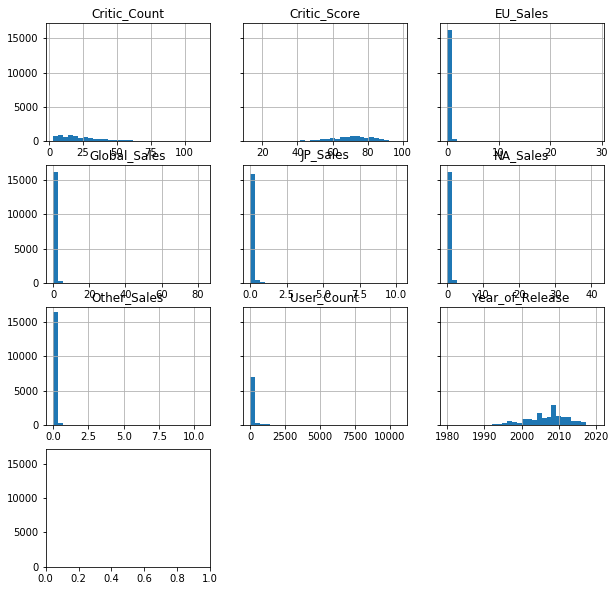

In [15]:
# 数値を値として持っている項目のヒストグラム
display(data.describe())

hist = data.hist(bins=30, sharey=True, figsize=(10, 10))

y,False,True
Name,,
Beyblade Burst,0.000068,0.000000
Fire Emblem Fates,0.000000,0.000486
Frozen: Olaf's Quest,0.000136,0.000000
Haikyu!! Cross Team Match!,0.000068,0.000000
Tales of Xillia 2,0.000068,0.000000
'98 Koshien,0.000068,0.000000
.hack//G.U. Vol.1//Rebirth,0.000068,0.000000
.hack//G.U. Vol.2//Reminisce,0.000068,0.000000
.hack//G.U. Vol.2//Reminisce (jp sales),0.000068,0.000000


y,False,True
Platform,,
2600,0.007298,0.012640
3DO,0.000205,0.000000
3DS,0.032192,0.023335
DC,0.003137,0.002917
DS,0.137294,0.067574
GB,0.003001,0.026252
GBA,0.051289,0.034030
GC,0.034784,0.022363
GEN,0.001159,0.005834


y,False,True
Genre,,
Action,0.201282,0.203794
Adventure,0.086079,0.019942
Fighting,0.049519,0.059825
Misc,0.108042,0.080739
Platform,0.047405,0.093872
Puzzle,0.035809,0.026751
Racing,0.072983,0.087062
Role-Playing,0.088534,0.098249
Shooter,0.072915,0.123541


y,False,True
Publisher,,
10TACLE Studios,0.000205,0.000000
1C Company,0.000205,0.000000
20th Century Fox Video Games,0.000342,0.000000
2D Boy,0.000068,0.000000
3DO,0.002395,0.000487
49Games,0.000068,0.000000
505 Games,0.012593,0.003408
5pb,0.004243,0.000000
7G//AMES,0.000205,0.000000


y,False,True
User_Score,,
0,0.000116,0.000000
0.2,0.000233,0.000000
0.3,0.000233,0.000000
0.5,0.000233,0.000000
0.6,0.000233,0.000000
0.7,0.000233,0.000000
0.9,0.000233,0.000000
1,0.000233,0.000000
1.1,0.000233,0.000000


y,False,True
Developer,,
10tacle Studios,0.000115,0.000000
"10tacle Studios, Fusionsphere Systems",0.000231,0.000000
"1C, 1C Company",0.000231,0.000000
"1C, Ino-Co, 1C Company",0.000231,0.000000
"1C, Various, 1C Company",0.000115,0.000000
1C: Maddox Games,0.000231,0.000000
1C:Ino-Co,0.000231,0.000000
1st Playable Productions,0.001154,0.001401
2015,0.000115,0.000000


y,False,True
Rating,,
AO,0.000000,0.000702
E,0.406404,0.369382
E10+,0.147901,0.111657
EC,0.000938,0.000000
K-A,0.000117,0.001404
M,0.142036,0.247191
RP,0.000352,0.000000
T,0.302252,0.269663


Year_of_Release


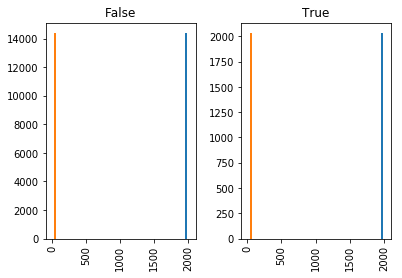

NA_Sales


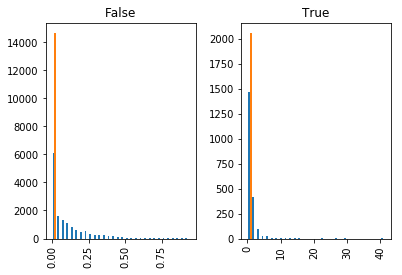

EU_Sales


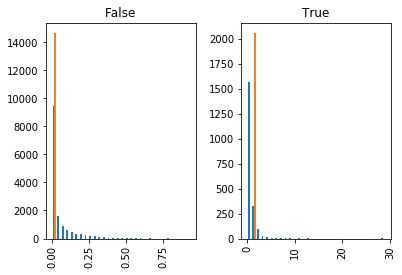

JP_Sales


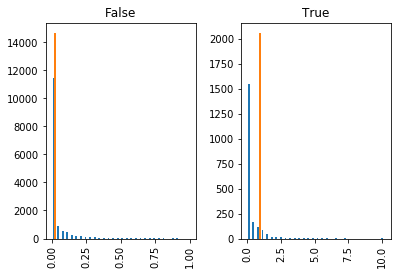

Other_Sales


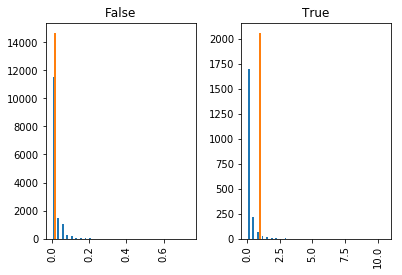

Global_Sales


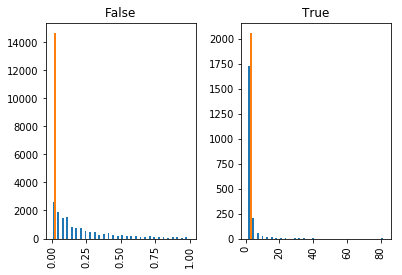

Critic_Score


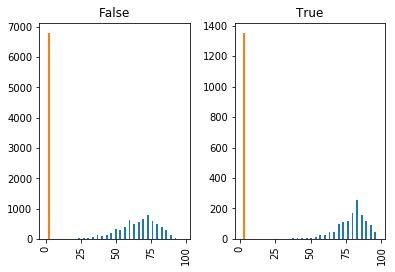

Critic_Count


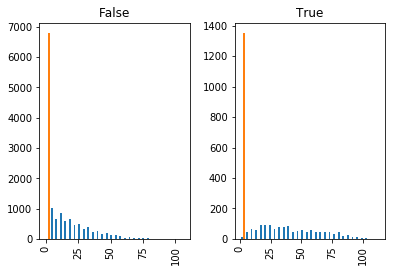

User_Count


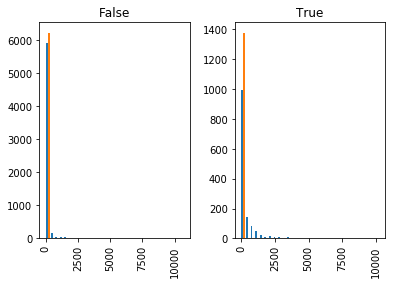

y


ValueError: ignored

In [16]:
# 各項目が予測ターゲット「y」にどのように関係してるか確認 
for column in data.select_dtypes(include=['object']).columns:
    if column != 'y':
        display(pd.crosstab(index=data[column], columns=data['y'], normalize='columns'))

for column in data.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = data[[column, 'y']].hist(by='y', bins=30)
    plt.show()

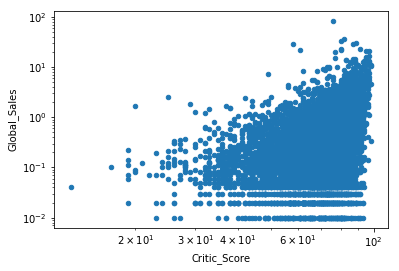

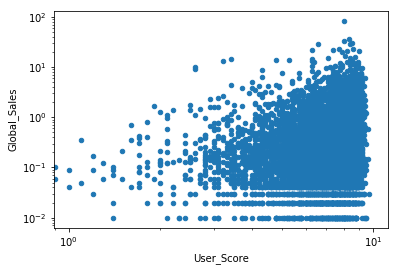

In [17]:
# ゲームのレビュー（User_ScoreとCritic_Score）と販売量（Global_Sales）の相関性
# 対数目盛を使ってグラフする
viz = data.filter(['User_Score','Critic_Score', 'Global_Sales'], axis=1)
viz['User_Score'] = pd.Series(viz['User_Score'].apply(pd.to_numeric, errors='coerce'))
viz['User_Score'] = viz['User_Score'].mask(np.isnan(viz["User_Score"]), viz['Critic_Score'] / 10.0)
viz.plot(kind='scatter', logx=True, logy=True, x='Critic_Score', y='Global_Sales')
viz.plot(kind='scatter', logx=True, logy=True, x='User_Score', y='Global_Sales')
plt.show()

In [0]:
# 特徴量として使わない項目を除外
data = data.drop(['Name', 'Year_of_Release', 'NA_Sales', 'EU_Sales', 'JP_Sales',
                  'Other_Sales', 'Global_Sales', 'Critic_Count', 'User_Count', 'Developer'], axis=1)


In [0]:
# 欠損データを除外
data = data.dropna()
 

In [0]:
# User_Scoreの数値以外の値を処理
data['User_Score'] = data['User_Score'].apply(pd.to_numeric, errors='coerce')
 
# Critic_Scoreの1/10をUser_SocoreのNaNへ代入
data['User_Score'] = data['User_Score'].mask(np.isnan(data["User_Score"]), data['Critic_Score'] / 10.0)


In [21]:
data.groupby('y').count()

,Platform,Genre,Publisher,Critic_Score,User_Score,Rating
y,,,,,,
False,6677,6677,6677,6677,6677,6677
True,1344,1344,1344,1344,1344,1344


In [0]:
# 予測ターゲットを扱いやすいように処理
data['y'] = data['y'].apply(lambda y: 'yes' if y == True else 'no')
 
# 全ての特徴量をダミー変数化
model_data = pd.get_dummies(data)

In [0]:
X = model_data.drop(['y_no', 'y_yes'], axis=1)
y = model_data[['y_no', 'y_yes']]

In [0]:
# 3つのデータセットへ分別
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [0]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)

In [26]:
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [27]:
model.score(X_train, y_train)

0.99722895739522

In [28]:
model.score(X_test, y_test)

0.8274143302180685

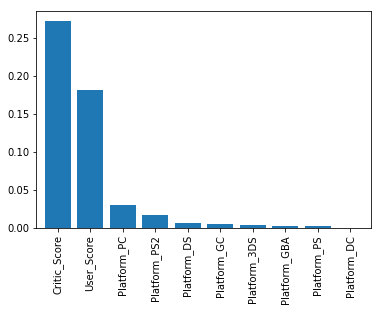

In [29]:
# モデル構築の中でどの変数が重要な役割を担ったのかを定量的に把握する
s = pd.Series(model.feature_importances_, 
              index=X_test.columns )

# 取得した値を降順に表示
s[:10].sort_values(ascending=False).plot.bar(width=0.8,color='C0')